In [146]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [191]:
(dataset_train, dataset_test), info = tfds.load('stanford_dogs',as_supervised = True, with_info = True, split = [tfds.Split.TRAIN, tfds.Split.TEST])

In [192]:
info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.
',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image

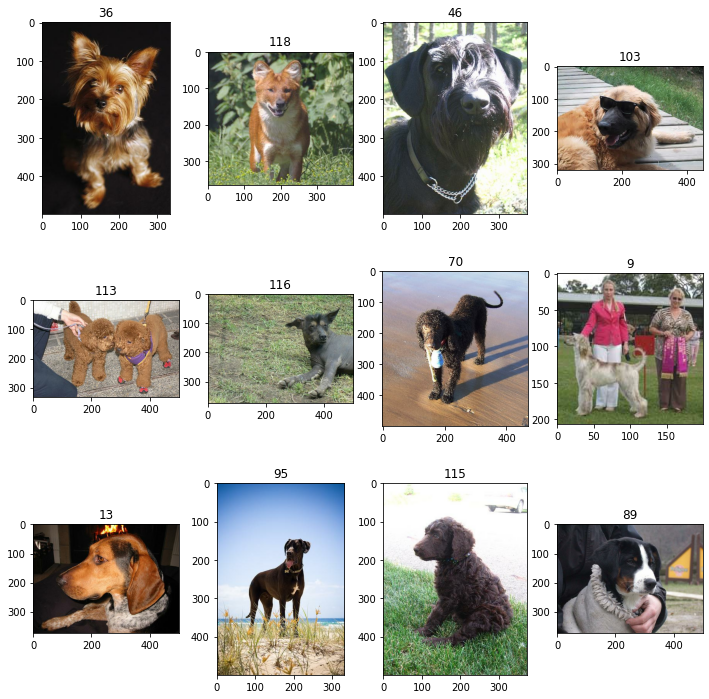

In [195]:
get_label_name = info.features['label'].int2str
def view(dataset):
  plt.figure(figsize = (12,12))
  plot_idx = 0
  for data in dataset.take(12):
    (image, label) = data
    plot_idx += 1
    plt.subplot(3,4,plot_idx)
    label = label.numpy()
    plt.title('%s' %label)
    plt.imshow(image.numpy())
view(dataset_train)


처음에는 dataset_train과 dataset_test에 저장된 label의 type가 문자열인줄 알았지만 그렇지가 않았고 get_label_names라는 리스트에 int2str을 이용해 문자열을 저장해 주었기 때문에 그렇게 plt의 image의 제목으로 지정되었던 것이다.

In [196]:
(first_image, first_label) = list(dataset_train.take(1))[0]
print(first_label)
print(first_image.numpy())
print(first_image.numpy().shape)

tf.Tensor(36, shape=(), dtype=int64)
[[[14 14 14]
  [14 14 14]
  [14 14 14]
  ...
  [19 17 20]
  [19 17 20]
  [19 17 20]]

 [[14 14 14]
  [14 14 14]
  [14 14 14]
  ...
  [19 17 20]
  [19 17 20]
  [19 17 20]]

 [[14 14 14]
  [14 14 14]
  [14 14 14]
  ...
  [19 17 20]
  [19 17 20]
  [19 17 20]]

 ...

 [[19 19 19]
  [18 18 18]
  [18 18 18]
  ...
  [23 21 22]
  [24 22 23]
  [24 22 23]]

 [[19 19 19]
  [18 18 18]
  [18 18 18]
  ...
  [22 20 21]
  [22 20 21]
  [23 21 22]]

 [[19 19 19]
  [18 18 18]
  [18 18 18]
  ...
  [21 19 20]
  [21 19 20]
  [22 20 21]]]
(500, 333, 3)


dataset를 normalization하는 과정(tf.keras.fit()에 적용하기 위한 처리 과정)


In [202]:
from sklearn.preprocessing import LabelEncoder
def format(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.0
  image = tf.image.resize(image, (128,128))
  return image, label
dataset_train = dataset_train.map(format)
dataset_test = dataset_test.map(format)

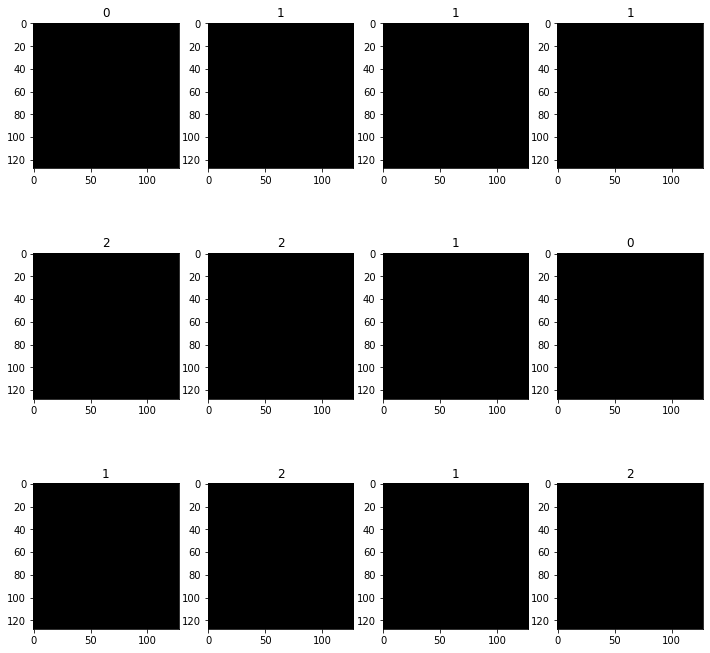

In [203]:
view(dataset_train)

In [204]:
print(dataset_train)
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples
print(test_data_len)

<DatasetV1Adapter shapes: ((128, 128, 3), ()), types: (tf.float32, tf.int64)>
8580


Data Augmentataion 진행

In [205]:
#위/아래로 뒤집거나 오른쪽/왼쪽으로 뒤집음
def augment_flip(image):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  return image
#사진의 색을 바꾸거나 밝기 등의 조건을 바꿈
def augment_color(image):
  image = tf.image.random_hue(image, max_delta= 0.08)
  image = tf.image.random_saturation(image, lower = 0.7, upper = 1.3)
  image = tf.image.random_brightness(image, 0.05)
  image = tf.image.random_contrast(image, lower = 0.8, upper = 1)
  image = tf.clip_by_value(image, clip_value_min = 0, clip_value_max=1)
  return image

def augment_rotation(image):
  return tf.image.rot90(image, tf.random.uniform(shape = [], minval = 0,maxval = 4,dtype = tf.int32))

def augment_inversion(image):
  random = tf.random.uniform(shape = [], minval = 0, maxval = 1)
  if random > 0.5:
    image = tf.math.multiply(image, -1)
    image = tf.math.add(image, 1)
  return image

def augment_data(image, label):
  image = augment_flip(image)
  image = augment_color(image)
  image = augment_rotation(image)
  image = augment_inversion(image)
  return image, label




In [206]:
dataset_train = dataset_train.map(augment_data)

In [207]:
(first_image, first_label) = list(dataset_train.take(200))[50]
print(first_image.numpy())
print(first_label.numpy())

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
1


In [208]:
batch_size = 16
datset_train = dataset_train.shuffle(buffer_size = train_data_len)
dataset_train = dataset_train.batch(batch_size)
dataset_test = dataset_test.batch(batch_size)
print(dataset_train)

<DatasetV1Adapter shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>


신경망 모델 만들기

In [209]:
model = tf.keras.Sequential()
#First Convolution
model.add(tf.keras.layers.Conv2D(input_shape = (128,128,3), filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))
#Second Convolution
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))
#Third Convolution
model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))
#Fourth Convolution
model.add(tf.keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides=(2,2)))
#Flatten
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
#Dense Layer
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dense(216, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(120, activation = 'softmax'))


In [210]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 28, 28, 256)       295168    
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 12, 12, 512)     

In [211]:
adam_optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer = adam_optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


In [212]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)

In [213]:
history = model.fit(dataset_train.repeat(), steps_per_epoch = train_data_len/batch_size, epochs = 100,callbacks = [early_stopping_callback])

Epoch 1/100
750/750 [==============================] - 31s 41ms/step - loss: 1.4844 - accuracy: 0.3277
Epoch 2/100
750/750 [==============================] - 31s 41ms/step - loss: 1.1118 - accuracy: 0.3273
Epoch 3/100
750/750 [==============================] - 30s 40ms/step - loss: 1.1116 - accuracy: 0.3328
Epoch 4/100
750/750 [==============================] - 30s 40ms/step - loss: 1.1106 - accuracy: 0.3335
Epoch 5/100
750/750 [==============================] - 31s 41ms/step - loss: 1.1132 - accuracy: 0.3229
Epoch 6/100
750/750 [==============================] - 30s 40ms/step - loss: 1.1181 - accuracy: 0.3332
Epoch 7/100
750/750 [==============================] - 30s 41ms/step - loss: 1.1108 - accuracy: 0.3365
Epoch 8/100
750/750 [==============================] - 30s 40ms/step - loss: 1.1109 - accuracy: 0.3332
Epoch 9/100
750/750 [==============================] - 30s 40ms/step - loss: 1.1104 - accuracy: 0.3273
Epoch 10/100
750/750 [==============================] - 30s 40ms/step - l

그동안 몰랐던 것이 있는데 val_loss와 val_accuracy가 도출되는 이유가 

In [214]:
model.evaluate(dataset_test)

537/537 [==============================] - 15s 28ms/step - loss: 1.1002 - accuracy: 0.3442


[1.1002124547958374, 0.34417250752449036]

정확도가 9.67%가량으로 터무니없이 낮다.

epoch수를 늘리거나 이미지 증식을 해야한다. class의수가 120으로 너무 많은 탓도 있다.

-> class의 수를 6개로 줄이고 데이터 증식까지 했음에도 불구하고 정확도는 17.78%로 밖에 오르지 않았다. -> epoch수를 늘리면 더 정확도가 올라갈까??

-> 나의 생각에 오류가 있었음을 알 수 있다. CNN이라는것이 이미지의 특징을 이용해 학습을 한 뒤에 class별로 분류하는 것인데 나는 class를 임의로 줄임으로서 오히려 학습 과정에서 특징을 도출해 내기가 더 어려웠던 것이다. -> 다시 해보니 정확도가 33.36%까지 올랐다.